<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/Skimlit_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

This is an NLP model to make reading medical abstracts easier.

The paper replicated and the source of the dataset is at https://arxiv.or/abs/171006071 and https://arxiv.org/abs/1612.05251

In [1]:
!invidia-smi -L

/bin/bash: line 1: invidia-smi: command not found


## Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 33.07 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the pulmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start experimenting with numbers replaced by @ sing
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filenames for filenames in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

become one with the data (visualize, visualize, visualize)

In [6]:
# Create a function to read and write the lines of a document.
def get_lines(filename):
  """
  Read filenames (a text filename) and returns the lines of text as a list.

  Args:
    filename: a strin containing the target filpath.

  returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [7]:
# Read in the train lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

##### Think about the format of the data.

How the data should be represented.

```
`[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeatin and the development of obasity .\n',
   'totoal lines': 11},
  -----]

```

Function to create the dataset to be in the same format as above.

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of directories of abstract line data.

  Takes in dilname, reads it's contents and sorts throuh each line,
  extractin thins like the taret label, the text of the sentense,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_lines in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_lines.split("\t")
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 735 ms, sys: 113 ms, total: 848 ms
Wall time: 1.08 s


In [11]:
# Check the abstract of the training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that the data is in the form a dict, it is easy to turn it into a dataframe.

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Find the distributions of labels.
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

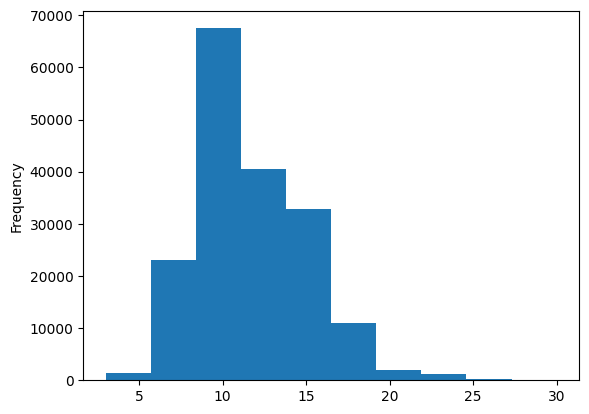

In [14]:
# Check the langth of different lines.
train_df.total_lines.plot.hist()

### Get list of sentences.

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numerical labels (ML models require numeric labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# Check what one hot encoder labels look like.
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import sklearn
print(sklearn.__version__)

1.2.2


In [19]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels


In [20]:
# Extract labels ("Target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names and number of classes form LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Startin a series of modellling eperiments...

Try Different models and see what works the best to the problem at hand.

 start with the baseline model.

## Model 0: ettin a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline.
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data.
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions using the baseline model.
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

#### Dowload the helper functions.

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-06 04:30:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-06 04:30:44 (78.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
from helper_functions import calculate_results

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the data (that is the texts) for deep seqeunce models

Before any deep learning modelin you need to create vectorization and embedding layers

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

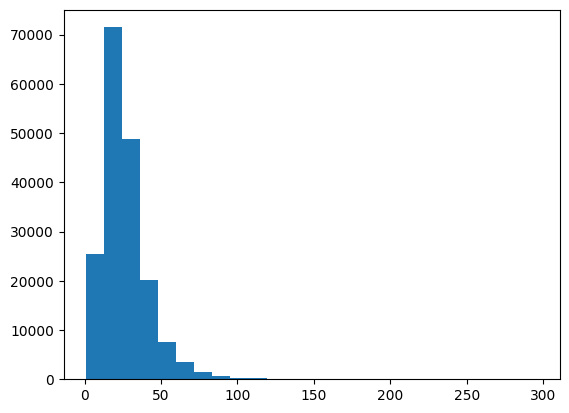

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [32]:
# How long of a sentence length covers 95% os examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Find the maximum length of the sentences
max(sent_lens)

296

### Create text vectorizer layer

Make a layer which maps texts from words to numbers.

In [34]:
max_tokens = 68000

In [35]:
# Create a text vectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters.
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len
                                    )

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
# Tes tht text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text: \n {target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text: 
 none of the adverse events reported ( taurine pn : n = @ ; control pn : n = @ ) were treatment related .

Length of text: 25

Vectorized text: [[ 1113     4     2   118   124   205 13638  2716    40    35  2716    40
      9    19   328     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [38]:
 # Number of words in the training vocabulary
 rct_20k_text_vocab = text_vectorizer.get_vocabulary()
 print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
 print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
 print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the configuration of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create Custom Text Embeddin

In [40]:
# Create token embeddin layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim=128,
                                   mask_zero=True,
                                   name="token_embedding")

In [41]:
# Example of a sentence that have undergone embedding.
print(f'Sentence before vectorization: \n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f"The vectorized text: /n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f'The embedded sentence:\n\n {embedded_sentence}')
print(f'Embedding sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
 none of the adverse events reported ( taurine pn : n = @ ; control pn : n = @ ) were treatment related .
The vectorized text: /n [[ 1113     4     2   118   124   205 13638  2716    40    35  2716    40
      9    19   328     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
The embedded sentence:

 [[[-0.02282136 -0.01673876 -0.00849658 ...  0.02781094  0.00392618
   -0.02430754]
  [-0.03774059  0.04481474  0.04215853 ... -0.04549853  0.01463847
    0.0111944 ]
  [ 0.01636722 -0.0394703  -0.03655044 ... -0.03574871  0.04943076
   -0.02150792]
  ...
  [ 0.00371666  0.0392985  -0.02431668 ... -0.04677726  0.02425731
    0.02342539]
  [ 0.00371666  0.0392985  -0.02431668 ... -0.04677726  0.02425731
    0.02342539]
  [ 0.00371666  0.0392985  -0.02431668 ... -0.0467

## Creating dataset (Make sure the data loads as fastr a possible)

Use: tf.data API

In [42]:
# Turn the data into tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

len(train_dataset)

180040

In [43]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

len(train_dataset)

5627

## Model 1: Conv1D with token embeddingsm

In [44]:
# Create 1D conv model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [46]:
len(train_dataset)

5627

In [47]:
# Fit model_1
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))  # Validaton on onnly 10% of the datches.
                              )

Epoch 1/3
562/562 [==============================] - 21s 31ms/step - loss: 0.9055 - accuracy: 0.6415 - val_loss: 0.6797 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6537 - accuracy: 0.7564 - val_loss: 0.6252 - val_accuracy: 0.7746
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6143 - accuracy: 0.7751 - val_loss: 0.5968 - val_accuracy: 0.7846


In [48]:
# Make Evaluation on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5976 - accuracy: 0.7869


[0.5976218581199646, 0.7869058847427368]

In [49]:
# Make prediction (The model displays a prediction probability to each class.)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.3108207e-01, 1.6156541e-01, 7.2725318e-02, 3.0655137e-01,
        2.8075770e-02],
       [4.5340028e-01, 2.5772053e-01, 1.6567627e-02, 2.6410449e-01,
        8.2070753e-03],
       [1.5013269e-01, 5.7623992e-03, 1.8479702e-03, 8.4222162e-01,
        3.5318637e-05],
       ...,
       [5.2200594e-06, 5.0341396e-04, 6.3488085e-04, 3.7281898e-06,
        9.9885273e-01],
       [4.9519751e-02, 4.7612497e-01, 9.2714585e-02, 6.2683500e-02,
        3.1895712e-01],
       [1.5240762e-01, 7.0934927e-01, 3.7648745e-02, 4.3000024e-02,
        5.7594262e-02]], dtype=float32)

In [50]:
# Conver the prediction probabilities to classes
# Argmax return the position in the array where there is a high prediction probability.
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [51]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [52]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.69058652191183,
 'precision': 0.783517826730976,
 'recall': 0.7869058652191182,
 'f1': 0.7843300749908794}

 ## Model 2: Feature extraction with pretrained token embeddings

 The use of universal sentence encoder.


In [53]:
# Download pretrained TensorFlow Hub use
import tensorflow_hub as hub
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(model_url,
                                        trainable=False,
                                        name="Universal_sentence_encoder")

In [54]:
# TRest the pretrained embedding on a sentence.
random_train_sentence = random.choice(train_sentences)
print(f"Random sentences:\n {random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'sentence after embedding:\n{use_embedding_sentence[0][:30]} \n')
print(f'Length of sentence embedding: {len(use_embedding_sentence[0])}')

Random sentences:
 all patients underwent three intra-articular injections of condrotide or hyalubrix with an interval of @week .
sentence after embedding:
[-5.00109382e-02  4.24333209e-08  1.17611242e-02  7.19382986e-03
 -1.79713573e-02  7.80818164e-02  6.50589243e-02  2.78612152e-02
 -5.55119850e-02  3.01330648e-02  9.60283056e-02 -3.90888415e-02
  1.19303316e-02  5.48566021e-02 -1.46502024e-02 -1.53607512e-02
 -1.00522794e-01 -1.63018219e-02 -5.88680990e-02  5.12661487e-02
  8.59307945e-02  3.86408865e-02 -2.47694328e-02  7.84196481e-02
  1.18881650e-02  2.65660677e-02  5.34542017e-02 -5.33546507e-02
  4.21372019e-02  3.30849923e-02] 

Length of sentence embedding: 512


### Building and fitting NLP ffeature extraction model using pretrained embedding

In [55]:
# Define feature extraction layer.
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extraction')

# Compile the model.
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [56]:
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [57]:
# Fit the model 2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9171 - accuracy: 0.6500 - val_loss: 0.7946 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7673 - accuracy: 0.7022 - val_loss: 0.7536 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7493 - accuracy: 0.7131 - val_loss: 0.7346 - val_accuracy: 0.7168


In [58]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7379 - accuracy: 0.7157


[0.7379202842712402, 0.7157421112060547]

In [59]:
# Model 2 predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.3969986e-01, 3.5862410e-01, 2.9353772e-03, 1.8949127e-01,
        9.2493808e-03],
       [3.5583690e-01, 5.0012386e-01, 4.0606498e-03, 1.3607232e-01,
        3.9062807e-03],
       [2.4672902e-01, 1.3642615e-01, 2.1961771e-02, 5.5242354e-01,
        4.2459484e-02],
       ...,
       [1.8561813e-03, 6.1981701e-03, 5.9415795e-02, 9.1202086e-04,
        9.3161792e-01],
       [4.2956835e-03, 4.1832957e-02, 1.9205843e-01, 1.4329732e-03,
        7.6038003e-01],
       [1.6708736e-01, 2.4227968e-01, 5.2371484e-01, 5.8907950e-03,
        6.1027303e-02]], dtype=float32)

In [60]:
# Convert the prediction probabilities to labels.
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [61]:
# Culculate results from on the validation dataset.
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.57420892360652,
 'precision': 0.7166449833264094,
 'recall': 0.7157420892360652,
 'f1': 0.7130277092837617}

## Model 3: Conv1D with charcter embedding

In the reaserch paper they used both charactor and token level embedding


### Creating a character-level tokenizer

In [62]:
# Make fuctions to spit sentences into characters.
def split_chars(text):
  return ' '.join(list(text))

# Test the split
split_chars(random_train_sentence)

'a l l   p a t i e n t s   u n d e r w e n t   t h r e e   i n t r a - a r t i c u l a r   i n j e c t i o n s   o f   c o n d r o t i d e   o r   h y a l u b r i x   w i t h   a n   i n t e r v a l   o f   @ w e e k   .'

In [63]:
 # Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
# What is the average characer length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

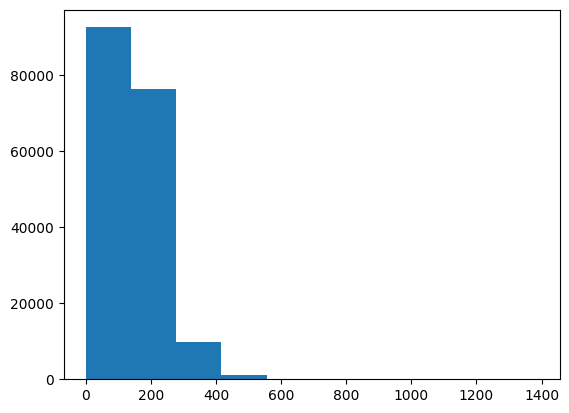

In [65]:
# Check the distribution of the sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10)

In [66]:
# Find what character length coves 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create a char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

In [69]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [70]:
# Check char vocab start
char_vocab = char_vectorizer.get_vocabulary()
print(f"number of diff chars: {len(char_vocab)}")
print(f'5 most common char: {char_vocab[:5]}')
print(f'5 least common char: {char_vocab[-5:]}')

number of diff chars: 28
5 most common char: ['', '[UNK]', 'e', 't', 'i']
5 least common char: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nvectorized chars: \n{vectorized_chars}')
print(f'\n Length of the vectorized chars: {len(vectorized_chars[0])}')

charified text:
 w e   d e m o n s t r a t e d   t h a t   p l a s m a   t r e a t m e n t   w i t h   t h e   p l a s m a d e r m   v u - @   d e v i c e   i s   s a f e   a n d   e f f e c t i v e   i n   p a t i e n t s   w i t h   c h r o n i c   v e n o u s   l e g   u l c e r s   .
Length of random_train_chars: 115

vectorized chars: 
[[20  2 10  2 15  7  6  9  3  8  5  3  2 10  3 13  5  3 14 12  5  9 15  5
   3  8  2  5  3 15  2  6  3 20  4  3 13  3 13  2 14 12  5  9 15  5 10  2
   8 15 21 16 10  2 21  4 11  2  4  9  9  5 17  2  5  6 10  2 17 17  2 11
   3  4 21  2  4  6 14  5  3  4  2  6  3  9 20  4  3 13 11 13  8  7  6  4
  11 21  2  6  7 16  9 12  2 18 16 12 11  2  8  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating char embedding layer


In [72]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")


In [73]:
# Test character embedding layer.
print(f"Charified text:\n {random_train_chars} \n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. \n {char_embed_example}")
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 w e   d e m o n s t r a t e d   t h a t   p l a s m a   t r e a t m e n t   w i t h   t h e   p l a s m a d e r m   v u - @   d e v i c e   i s   s a f e   a n d   e f f e c t i v e   i n   p a t i e n t s   w i t h   c h r o n i c   v e n o u s   l e g   u l c e r s   . 

Embedded chars. 
 [[[-0.02366605 -0.04947995  0.03018823 ...  0.00151591  0.02372389
    0.03135312]
  [ 0.03691972  0.01809908  0.00562614 ...  0.02228099  0.04569105
    0.03478049]
  [ 0.0161605  -0.01291469 -0.01982275 ...  0.01965847 -0.00315388
    0.00184789]
  ...
  [-0.02752472 -0.0339657  -0.02006898 ...  0.01315976 -0.04370865
   -0.04024852]
  [-0.02752472 -0.0339657  -0.02006898 ...  0.01315976 -0.04370865
   -0.04024852]
  [-0.02752472 -0.0339657  -0.02006898 ...  0.01315976 -0.04370865
   -0.04024852]]]
Character embedding shape: (1, 290, 25)


### CHarector level embedding model

In [74]:
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')

# Compile the model.
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [75]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [76]:
# Create character level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2715 - accuracy: 0.4844 - val_loss: 1.0664 - val_accuracy: 0.5695
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0270 - accuracy: 0.5851 - val_loss: 0.9545 - val_accuracy: 0.6313
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9448 - accuracy: 0.6223 - val_loss: 0.8859 - val_accuracy: 0.6652


In [78]:
# Make predictions with charaster models
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.2788235 , 0.13714097, 0.29135215, 0.24163781, 0.05104558],
       [0.17113067, 0.25196835, 0.01732399, 0.5432185 , 0.01635853],
       [0.10681973, 0.4126378 , 0.06124776, 0.39398044, 0.02531433],
       ...,
       [0.03241848, 0.07577118, 0.10108154, 0.06140412, 0.7293247 ],
       [0.03359879, 0.3722441 , 0.1893248 , 0.05156508, 0.35326716],
       [0.43394795, 0.28698316, 0.19893424, 0.06197012, 0.01816444]],
      dtype=float32)

In [79]:
# Conver the prediction probabilities to class label's
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 3, 1, ..., 4, 1, 0])>

In [80]:
# Calc the results of model 3
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.69945716933668,
 'precision': 0.6404425866398576,
 'recall': 0.6469945716933668,
 'f1': 0.6380693395779035}

 ## Model 4: Combining pretrained token embedding and the charactor embedding (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper
5. Construct a model that takes token and character-level sequences as inputs and produce a sequence labels probabilities

In [81]:
# 1. Setup token inputs.model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24)) (char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embeddin)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create an output layer - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                      outputs=output_layer,
                      name='model_4_token_and_char'
                      )

In [82]:
model_4.summary()

Model: "model_4_token_and_char"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   ['token_i

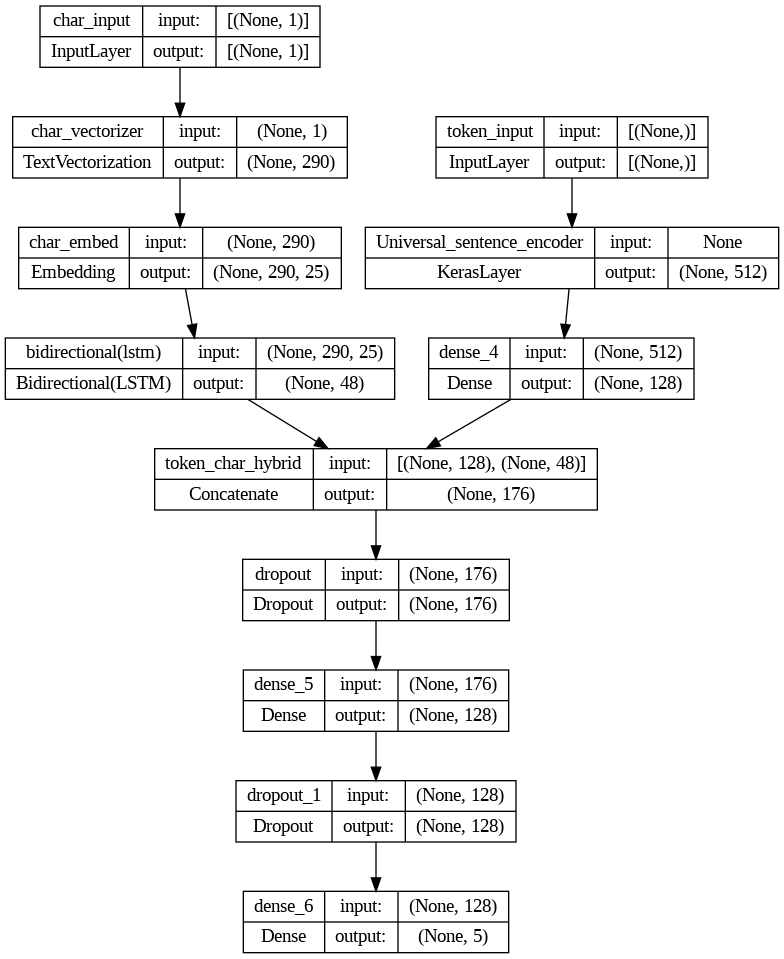

In [83]:
# Plot the hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [103]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),  # you can as well use SGD
                metrics=["accuracy"])

### Combining token and sharacter data into a tf.data.Dataset


In [99]:
# Combinr chars and tokens into a dataset.
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data.
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)   # make labels.
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))  # Combines the data and labels

# Prefetch and batch train data.
train_char_token_dataset = train_char_token_dataset.batch(23).prefetch(tf.data.AUTOTUNE)

In [100]:
# Repeat the process for the validation dataset.
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_label))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# Chesk the trainin char and token embeddin dataset.
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fiting a model on token and char level sequences

In [104]:
# FIt the model on tokena and char datasets.
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
782/782 [==============================] - 46s 43ms/step - loss: 0.9616 - accuracy: 0.6178 - val_loss: 0.7729 - val_accuracy: 0.7074
Epoch 2/3
782/782 [==============================] - 31s 40ms/step - loss: 0.7957 - accuracy: 0.6934 - val_loss: 0.7141 - val_accuracy: 0.7281
Epoch 3/3
782/782 [==============================] - 28s 36ms/step - loss: 0.7706 - accuracy: 0.7092 - val_loss: 0.6897 - val_accuracy: 0.7414


In [106]:
# Evaluate the model.
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 27s 29ms/step - loss: 0.6913 - accuracy: 0.7370


[0.6912770867347717, 0.7369588017463684]

In [107]:
# Make predictions for model 4 on the validation char token dataset.
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:5]

945/945 [==============================] - 22s 18ms/step


array([[0.42347553, 0.37295675, 0.00227124, 0.19697414, 0.00432243],
       [0.4277135 , 0.35832226, 0.00211928, 0.21078214, 0.00106278],
       [0.30735815, 0.12952673, 0.06013025, 0.47006628, 0.0329186 ],
       [0.02168847, 0.02827131, 0.8309946 , 0.01091342, 0.10813221],
       [0.04243403, 0.1161507 , 0.4525489 , 0.01849075, 0.37037563]],
      dtype=float32)

In [109]:
# Format the predection probablities into labels.
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
# Get results of token-char-hybrid model.
model_4_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy': 73.6958824308222,
 'precision': 0.7378368742611411,
 'recall': 0.7369588243082219,
 'f1': 0.7353107462057801}

## Model 5: Transfer learnin with pretrained token embeddings + character embeddings + positional embeddings